## Классификация возраста, пола и расы по лицу человека

Используйте публичные данные UTKfaces. https://susanqq.github.io/UTKFace/
В работе необходимо использовать данные Aligned&Cropped Faces, где произведены вырезы лиц с исходных изображений.

Изображения хранятся в формате jpg. В имени (почти!!!) каждого иображения имеется информации о человеке

$$[возраст]\_[пол]\_[раса]\_[время].jpg$$

Потребуются первые три параметра из названия каждого файлы.

В текущем файле реализована тренировка сверточной нейронной сети resnet50 для классификации возраста по фотографии. Текущая СНС используется с предобученными весами (transfer learning - перенос обучения) на датасете imagenet. Перенос обучения позволяет использовать веса сети с другого набора данных. Как правило, такой подход позволяет существенно поднять точность предсказания на новом наборе данных.

Задачи:
1. Переписать класс Dataset так, чтобы __getitem__ выдывал классы возраст, пол и раса. Задача регрессии для предсказания возраста является сложно, в этой связи будем решать ее как классификационную. Необходимо закодировать возраст в один из классов [(0, 5), (5, 14), (14, 30), (30, 45), (45, 60), (60, 120)], таким образом __getitem__ будет выдавать номер класса, которому принадлежит человек на фотографии.
Дополнительная задача (по желанию): при классификации ответом является возрастная, а не число. Можно получать возраст в числом выражении если использовать математическое ожидание по ответам нейронной сети. Для этого необходимо умножить ответы в виде Softmax на средние значения возраста в каждой группе и проссумировать все значения. 

2. Переписать класс Net. Добавить Mobilentv2 и Resnet34, так чтобы аргументом net можно было выбрать на основе какого экстрактора признаков построить сеть для классификации. Добавить дополнительные классификаторы для возраста и расы.

3. Обучить сеть. Попробуйте оптимизатор SGD и Adam. Визуализировать результаты на валидационном наборе данных.

Примечание: для тренировки лучше использовать GPU или colab.research.google.com с поддержкой GPU.

In [1]:
import numpy as np
import os
from PIL import Image
import torch
import torchvision
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import pandas as pd 
%matplotlib inline

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


Ниже реализован класс Dataset, который имеет три обязательных метода __init__, __len__, __getitem__.

- __init__ происходит инициализация переменных датасета.
- __len__ возращает количество изображений в датасете.
- __getitem__ возвращает изображение в формате PIL и значения классов age, gender, race по индексу.

Размер изображения установить $224 \times 224$. В случае медленного обучения на процессоре параметр можно уменьшить, но потребуется произвести изменения в месте крепления экстрактора признаков и классификатора нейронной сети.

In [2]:
import torch
from torch.utils import data

T = transforms.Compose([
    transforms.Resize([224,224]),
    transforms.ToTensor(),
])

class Dataset(data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, path, subset = 'train', test_part = 0.2, transform = None):
        'Initialization'
        self.path = path
        self.subset = subset
        self.transform = transform
        names = [it for it in os.listdir(path) if len(it.split('_')) > 3]
        names = [os.path.join(path, it) for it in names]
        np.random.seed(0)
        np.random.shuffle(names)
        if subset == 'train':
            self.ids = names[:int(len(names) * test_part)]
        elif subset == 'valid':
            self.ids = names[int(len(names) * test_part):]
        self.age_list = [(0, 5), (5,14), (14, 30), (30, 45), (45, 60), (60, 120)]

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.ids)
    

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        ID = self.ids[index]

        image = Image.open(ID)

        # Load data and get label
        age = int(ID.split('\\')[-1].split('_')[0])
        gender = int(ID.split('\\')[-1].split('_')[1])
        race = int(ID.split('\\')[-1].split('_')[2])
        
        for i in range(6):
            group_age = range(self.age_list[i][0], self.age_list[i][1])
            if age in group_age:
                age = i
        
        if self.transform:
            image = self.transform(image)
        
        return image, age, gender, race

In [3]:
train_data = Dataset('C:\\Users\\\\Vanya\\Desktop\\2 семестр\\Визуализация данных\\datasets\\UTKFace', subset='train', test_part = 0.8, transform = T) #0.2
valid_data = Dataset('C:\\Users\\\\Vanya\\Desktop\\2 семестр\\Визуализация данных\\datasets\\UTKFace', subset='valid', test_part = 0.8, transform = T)

In [4]:
print('train data len: ', train_data.__len__())
print('valid data len: ', valid_data.__len__())

train data len:  18964
valid data len:  4741


Ниже представлен пример получения изображения по индексу.

In [5]:
gender_dict = {0:"Мужчина", 1:"Женщина"}
race_dict = {0:"Белый", 1:"Черный", 2:"Азиат", 3:"Индус", 4:"Другой"}
age_dict = {0:"0-5", 1:"5-14", 2:"14-30", 3:"30-45", 4:"45-60", 5:"60+"}

Пол:  Мужчина
Возраст:  45-60
Раса:  Индус


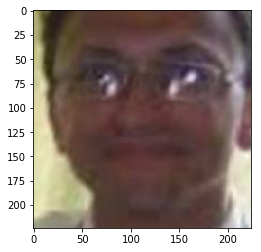

In [6]:
img, age, gender, race = train_data[100]
print("Пол: ", gender_dict.get(gender))
print("Возраст: ", age_dict.get(age))
print("Раса: ", race_dict.get(race))
plt.imshow(img.numpy().transpose(1,2,0));

Объекты train_data и valid_data передадим в DataLoader. Объект train_loader и valid_loader будут выдавать пачку изображения с правильными ответами (батчи).

In [7]:
train_loader = torch.utils.data.DataLoader(train_data, 
                                           batch_size=8, 
                                           shuffle=True)

# download and transform test dataset
valid_loader = torch.utils.data.DataLoader(valid_data,
                                          batch_size=8, 
                                          shuffle=False)

Пол:  tensor([1, 1, 1, 1, 0, 0, 0, 0])
Возраст:     tensor([2, 0, 0, 2, 2, 4, 5, 3])
Раса:    tensor([1, 3, 0, 0, 0, 0, 3, 4])


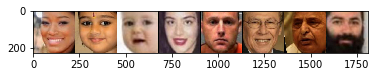

In [8]:
images, age, gender, race = next(iter(train_loader))
plt.imshow(torchvision.utils.make_grid(images).numpy().transpose(1,2,0))
print("Пол: ", gender)
print("Возраст:    ", age)
print("Раса:   ", race)

In [9]:
import torch.nn as nn
import torch.nn.functional as F

In [10]:
from torchvision.models import mobilenet_v2, resnet34, resnet50
import torch.nn.functional as F

class MTLnet(nn.Module): #Multi-task learning
    def __init__(self, net='mobilenetv2', pretrained=True):
        super(MTLnet, self).__init__()
        self.net = net
        if self.net == 'mobilenetv2':
            self.model = models.mobilenet_v2(pretrained)
            self.model.classifier = nn.Dropout(p=0.2, inplace=False)
                #nn.Linear(in_features=1280, out_features=1000, bias=True)
            
            self.model.gender_cls = nn.Linear(1280 * 7 * 7, 2)
            self.model.age_cls = nn.Linear(1280 * 7 * 7, 6)
            self.model.race_cls = nn.Linear(1280 * 7 * 7, 5)
            
            
        elif self.net == 'resnet34':
            self.model = models.resnet34(pretrained)
            self.model.gender_cls = nn.Linear(512, 2)
            self.model.age_cls = nn.Linear(512, 6)
            self.model.race_cls = nn.Linear(512, 5)
        elif self.net == 'resnet50':
            self.model = models.resnet50(pretrained) # initialize the resnet50
            self.model.gender_cls = nn.Linear(2048, 2)
            self.model.age_cls = nn.Linear(2048, 6)
            self.model.race_cls = nn.Linear(2048, 5)

    def forward(self, x):
        if (self.net == 'resnet50') or (self.net == 'resnet34'):
            x = self.model.conv1(x)
            x = self.model.bn1(x)
            x = self.model.relu(x)
            x = self.model.maxpool(x)
            x = self.model.layer1(x)
            x = self.model.layer2(x)
            x = self.model.layer3(x)
            x = self.model.layer4(x)
            x = self.model.avgpool(x) # without last fully connected(2048, 1000) layer
            x = x.view(x.size(0), -1)
            gender = self.model.gender_cls(x)
            age = self.model.age_cls(x)
            race = self.model.race_cls(x)
        
        if self.net == 'mobilenetv2':
            x = self.model.features(x)
            x = self.model.classifier(x) # only dropout
            x = x.view(x.size(0), -1)
            gender = self.model.gender_cls(x)
            age = self.model.age_cls(x)
            race = self.model.race_cls(x)

        return age, gender, race

In [11]:
#model = MTLnet(net='resnet50').to(device)
#model = MTLnet(net='resnet34').to(device)
#model = MTLnet(net='mobilenetv2', pretrained=True).to(device)
model = MTLnet(net='resnet34', pretrained=False).to(device)
#model.to(device)

In [12]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-5, momentum = 0.9)

In [13]:
epochs = 10
x = list(range(1, epochs + 1))
loss_list = []
val_loss_list = []
accuracy_age_list = []
v_accuracy_age_list = []
accuracy_gender_list = []
v_accuracy_gender_list = []
accuracy_race_list = []
v_accuracy_race_list = []

In [14]:
%%time
from IPython.display import clear_output

for epoch in range(epochs):  # loop over the dataset multiple times

    for phase in ['train', 'valid']:
        
        if phase == 'train':
            
            model.train(True)
            
            running_loss = 0.0
            correct = 0
            total = 0

            age_correct = 0
            gender_correct = 0
            race_correct = 0
            
            for i, data in enumerate(train_loader):
                # get the inputs; data is a list of [inputs, labels]
                inputs, age, gender, race = data[0].to(device), data[1].to(device), data[2].to(device), data[3].to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward + backward + optimize
                out_age, out_gender, out_race = model(inputs)

                loss_age = criterion(out_age, age)
                loss_gender = criterion(out_gender, gender)
                loss_race = criterion(out_race, race)
                
                loss = loss_age + loss_gender + loss_race

                loss.backward()
                
                optimizer.step()

                # print statistics
                running_loss += loss.item()

                _, age_pred = torch.max(out_age.data, 1)
                _, gender_pred = torch.max(out_gender.data, 1)
                _, race_pred = torch.max(out_race.data, 1)
                
                total += gender.size(0)
                
                age_correct += (age_pred == age).sum().item()
                gender_correct += (gender_pred == gender).sum().item()
                race_correct += (race_pred == race).sum().item()                        
            
        elif phase == 'valid':
            
            model.train(False)
            
            validation_loss = 0.
            v_correct = 0
            v_total = 0
            
            v_age_correct = 0
            v_gender_correct = 0
            v_race_correct = 0

            for i, v_data in enumerate(valid_loader):
                v_loss_age = 0
                v_loss_gender = 0
                v_loss_race = 0
                
                v_inputs, v_age, v_gender, v_race = v_data[0].to(device), v_data[1].to(device), v_data[2].to(device), v_data[3].to(device)

                v_out_age, v_out_gender, v_out_race = model(v_inputs)


                v_loss_age += criterion(v_out_age, v_age)
                v_loss_gender += criterion(v_out_gender, v_gender)
                v_loss_race += criterion(v_out_race, v_race)

                validation_loss += v_loss_age.item() + v_loss_gender.item() + v_loss_race.item()

                _, v_age_pred = torch.max(v_out_age.data, 1)
                _, v_gender_pred = torch.max(v_out_gender.data, 1)
                _, v_race_pred = torch.max(v_out_race.data, 1)

                v_total += v_gender.size(0)
                
                v_age_correct += (v_age_pred == v_age).sum().item()
                v_gender_correct += (v_gender_pred == v_gender).sum().item()
                v_race_correct += (v_race_pred == v_race).sum().item()
                
    print("Epoch: %5d, loss: %.3f,val_loss: %.3f,age(acc/v_acc): %.3f / %.3f,gender(acc/v_acc):%.3f / %.3f,race(acc/v_acc): %.3f / %.3f"%
          (epoch + 1, running_loss / len(train_loader), validation_loss / len(valid_loader), 
           age_correct / total, v_age_correct / v_total,
           gender_correct / total, v_gender_correct / v_total,
           race_correct / total, v_race_correct / v_total))            
    
    loss_list.append(running_loss / len(train_loader))
    val_loss_list.append(validation_loss / len(valid_loader))
    
    accuracy_age_list.append(age_correct / total)
    v_accuracy_age_list.append(v_age_correct / v_total)
    
    accuracy_gender_list.append(gender_correct / total)
    v_accuracy_gender_list.append(v_gender_correct / v_total)
    
    accuracy_race_list.append(race_correct / total)
    v_accuracy_race_list.append(v_race_correct / v_total)

Epoch:     1, loss: 3.734,val_loss: 3.647,age(acc/v_acc): 0.350 / 0.361,gender(acc/v_acc):0.566 / 0.589,race(acc/v_acc): 0.417 / 0.436
Epoch:     2, loss: 3.628,val_loss: 3.535,age(acc/v_acc): 0.358 / 0.371,gender(acc/v_acc):0.606 / 0.625,race(acc/v_acc): 0.433 / 0.486
Epoch:     3, loss: 3.533,val_loss: 3.438,age(acc/v_acc): 0.366 / 0.391,gender(acc/v_acc):0.632 / 0.643,race(acc/v_acc): 0.468 / 0.500
Epoch:     4, loss: 3.467,val_loss: 3.393,age(acc/v_acc): 0.380 / 0.394,gender(acc/v_acc):0.651 / 0.671,race(acc/v_acc): 0.482 / 0.502
Epoch:     5, loss: 3.410,val_loss: 3.340,age(acc/v_acc): 0.387 / 0.406,gender(acc/v_acc):0.667 / 0.681,race(acc/v_acc): 0.487 / 0.506
Epoch:     6, loss: 3.360,val_loss: 3.294,age(acc/v_acc): 0.396 / 0.405,gender(acc/v_acc):0.679 / 0.698,race(acc/v_acc): 0.488 / 0.507
Epoch:     7, loss: 3.301,val_loss: 3.234,age(acc/v_acc): 0.409 / 0.413,gender(acc/v_acc):0.692 / 0.699,race(acc/v_acc): 0.500 / 0.522
Epoch:     8, loss: 3.234,val_loss: 3.158,age(acc/v_acc

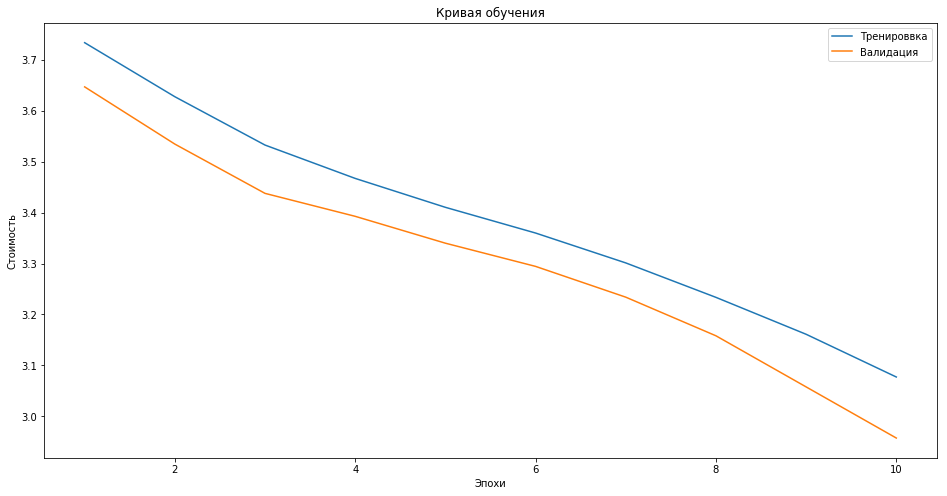

In [15]:
plt.figure(figsize=(16,8))
plt.title("Кривая обучения")
plt.plot(x, loss_list, label= 'Тренироввка')
plt.plot(x, val_loss_list, label= 'Валидация')
plt.xlabel("Эпохи")
plt.ylabel("Стоимость")
plt.legend();

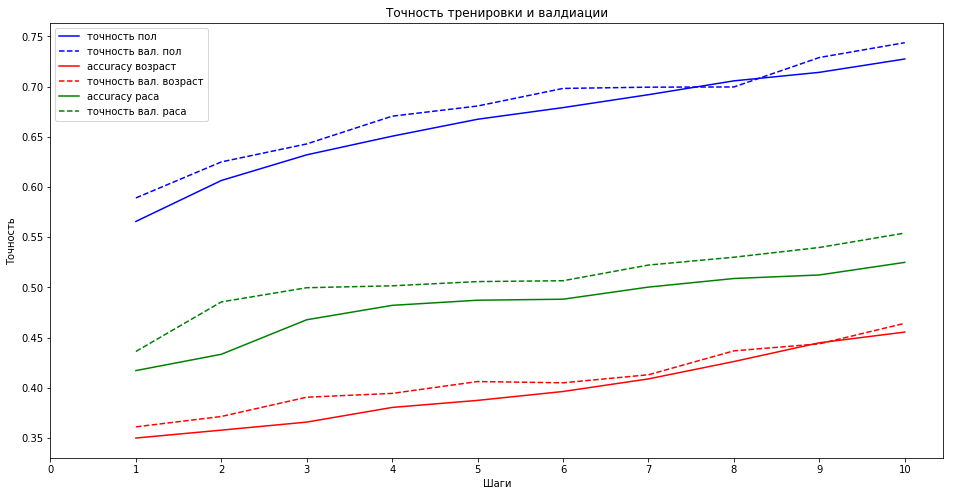

In [16]:
plt.figure(figsize=(16,8))
plt.title("Точность тренировки и валдиации")

plt.plot(x, accuracy_gender_list, 'b', label = 'точность пол')
plt.plot(x, v_accuracy_gender_list, 'b--', label = 'точность вал. пол')

plt.plot(x, accuracy_age_list, 'r', label = 'accuracy возраст')
plt.plot(x, v_accuracy_age_list, 'r--', label = 'точность вал. возраст')

plt.plot(x, accuracy_race_list, 'g', label = 'accuracy раса')
plt.plot(x, v_accuracy_race_list, 'g--', label = 'точность вал. раса')

plt.xticks(range(0, 11))
plt.xlabel("Шаги")
plt.ylabel("Точность")
plt.legend();

In [ ]:
df = pd.read_csv('results_1.csv') # 1.csv ResNet50 SGD lr=1e-5 

x = list(range(1, 11))
plt.figure(figsize=(16,8))
plt.title("ResNet50 тренировочная и валидационная точность")

plt.plot(x, df['accuracy gender'], 'b', label = 'точность пол')
plt.plot(x, df['validation accuracy gender'], 'b--', label = 'валидационная точность пол')
plt.axvline(x = 3, color='b', linestyle='-.', label = '3 epochs')

plt.plot(x, df['accuracy age'], 'r', label = 'точность возраст')
plt.plot(x, df['validation accuracy age'], 'r--', label = 'валидационная точность возраст')
plt.axvline(x = 4, color='r', linestyle='-.', label = '4 epochs')

plt.plot(x, df['accuracy race'], 'g', label = 'точность раса')
plt.plot(x, df['validation accuracy race'], 'g--', label = 'валидационная точность раса')
plt.axvline(x = 5, color='g', linestyle='-.', label = '5 epochs')

plt.xticks(range(1, 11))
plt.xlabel("Эпохи")
plt.ylabel("Точность")
plt.legend();

In [18]:
df = pd.DataFrame()
df['train loss'] = loss_list
df['val loss'] = val_loss_list
df['accuracy age'] = accuracy_age_list
df['validation accuracy age'] = v_accuracy_age_list
df['accuracy gender'] = accuracy_gender_list
df['validation accuracy gender'] = v_accuracy_gender_list
df['accuracy race'] = accuracy_race_list
df['validation accuracy race'] = v_accuracy_race_list
path = 'C:\\Users\\Vanya\\Desktop\\2 семестр\\Визуализация данных\\results_6.csv'
df.to_csv(path, index=False)
pd.read_csv('results_6.csv')

,train loss,val loss,accuracy age,validation accuracy age,accuracy gender,validation accuracy gender,accuracy race,validation accuracy race
0,3.733844,3.647028,0.349979,0.361105,0.565703,0.589116,0.417159,0.436195
1,3.627703,3.534655,0.357836,0.371441,0.606465,0.624974,0.433400,0.485552
2,3.532733,3.437830,0.365851,0.390635,0.632040,0.642902,0.467781,0.499684
3,3.467197,3.392731,0.380458,0.394432,0.650601,0.670534,0.482124,0.501582
4,3.410419,3.339961,0.387471,0.406243,0.667475,0.680658,0.487239,0.505800
5,3.359911,3.294381,0.396330,0.404978,0.679076,0.698165,0.488241,0.506644
6,3.301205,3.233936,0.408880,0.412993,0.691943,0.699430,0.500316,0.522253
7,3.233534,3.158039,0.426176,0.436828,0.705706,0.699641,0.508859,0.530057
8,3.161015,3.057631,0.444843,0.443788,0.714195,0.728960,0.512392,0.539760
9,3.077084,2.957172,0.455495,0.464248,0.727484,0.743725,0.524942,0.554103


# Сравнение результатов

### Кривые обучения ResNet34, ResNet50, MobileNetv2

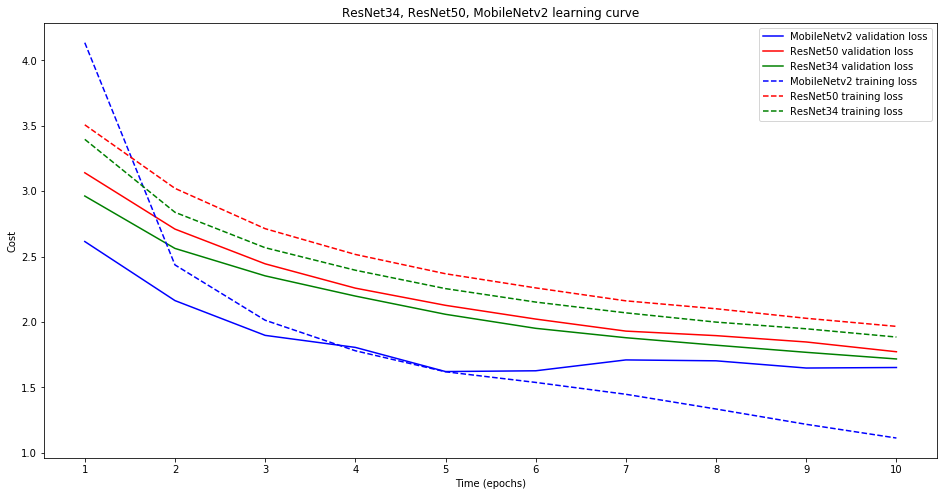

In [19]:
df_resnet50 = pd.read_csv('results_1.csv') # lr=1e-5
df_resnet34 = pd.read_csv('results_3.csv') # lr=1e-5
df_mobile = pd.read_csv('results_5.csv') # lr=1e-3

plt.figure(figsize=(16,8))
plt.title("ResNet34, ResNet50, MobileNetv2 learning curve")

plt.plot(x, df_mobile['validation loss'], 'b', label = 'MobileNetv2 validation loss')
plt.plot(x, df_resnet50['validation loss'], 'r', label = 'ResNet50 validation loss')
plt.plot(x, df_resnet34['validation loss'], 'g', label = 'ResNet34 validation loss')

plt.plot(x, df_mobile['training loss'], 'b--', label = 'MobileNetv2 training loss')
plt.plot(x, df_resnet50['training loss'], 'r--', label = 'ResNet50 training loss')
plt.plot(x, df_resnet34['training loss'], 'g--', label = 'ResNet34 training loss')

plt.xlabel("Time (epochs)")
plt.ylabel("Cost")
plt.xticks(range(1, 11))
plt.legend();

### Сравнение оптимизаторов Adam и SGD на примере MobileNetv2


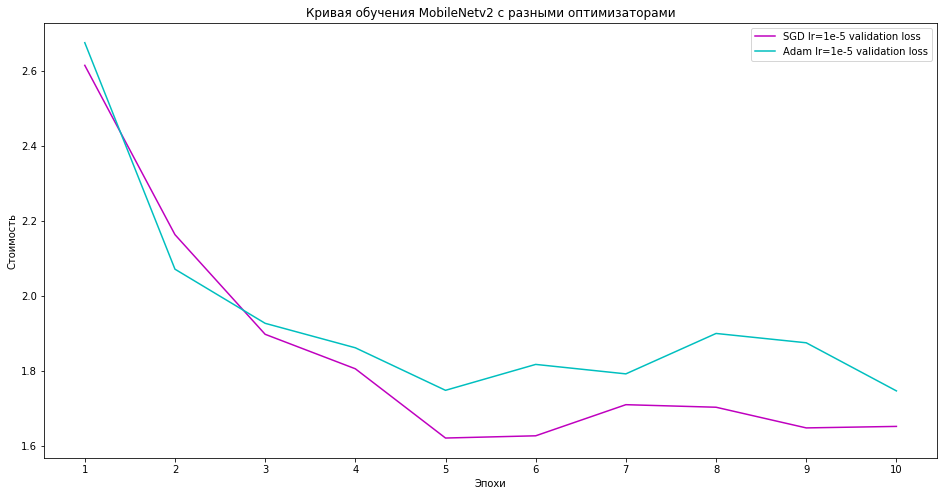

In [20]:
df_mobile_Adam = pd.read_csv('results_4.csv')
df_mobile_SGD = pd.read_csv('results_5.csv')

plt.figure(figsize=(16,8))
plt.title("Кривая обучения MobileNetv2 с разными оптимизаторами")
plt.plot(x, df_mobile_SGD['validation loss'], 'm', label = 'SGD lr=1e-5 validation loss')
plt.plot(x, df_mobile_Adam['validation loss'], 'c', label = 'Adam lr=1e-5 validation loss')
plt.xticks(range(1, 11))

plt.xlabel("Эпохи")
plt.ylabel("Стоимость")
plt.legend();

### Точность ResNet50

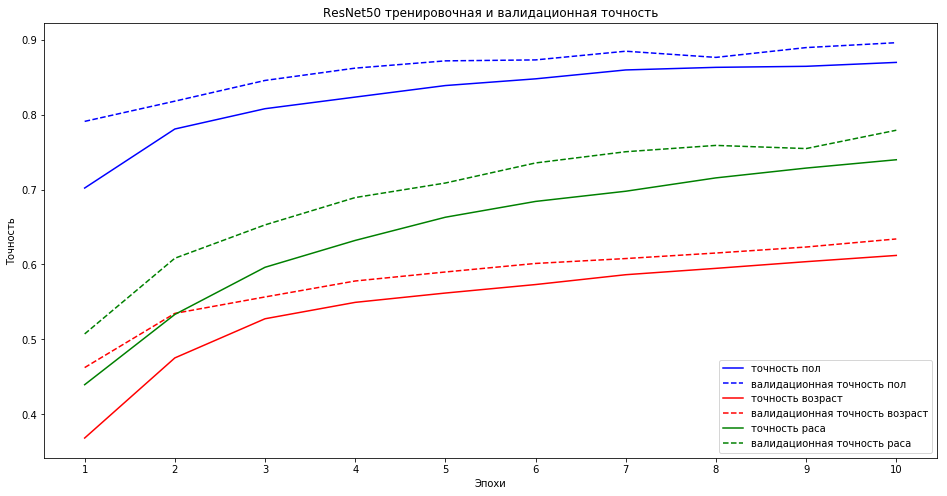

In [24]:
df = pd.read_csv('results_1.csv') # 1.csv ResNet50 SGD lr=1e-5 

x = list(range(1, 11))
plt.figure(figsize=(16,8))
plt.title("ResNet50 тренировочная и валидационная точность")

plt.plot(x, df['accuracy gender'], 'b', label = 'точность пол')
plt.plot(x, df['validation accuracy gender'], 'b--', label = 'валидационная точность пол')

plt.plot(x, df['accuracy age'], 'r', label = 'точность возраст')
plt.plot(x, df['validation accuracy age'], 'r--', label = 'валидационная точность возраст')

plt.plot(x, df['accuracy race'], 'g', label = 'точность раса')
plt.plot(x, df['validation accuracy race'], 'g--', label = 'валидационная точность раса')

plt.xticks(range(1, 11))
plt.xlabel("Эпохи")
plt.ylabel("Точность")
plt.legend();

### Точность ResNet34

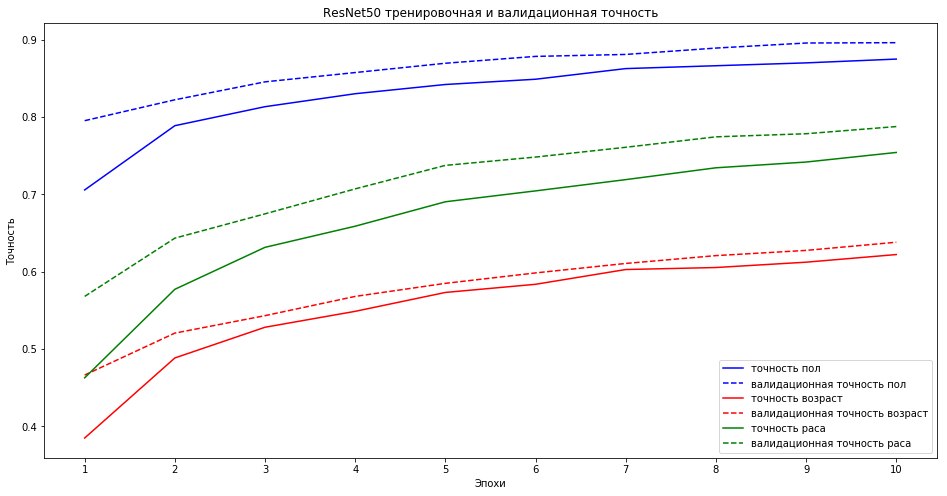

In [25]:
df = pd.read_csv('results_3.csv') # SGD lr=1e-5 

x = list(range(1, 11))
plt.figure(figsize=(16,8))
plt.title("ResNet50 тренировочная и валидационная точность")

plt.plot(x, df['accuracy gender'], 'b', label = 'точность пол')
plt.plot(x, df['validation accuracy gender'], 'b--', label = 'валидационная точность пол')

plt.plot(x, df['accuracy age'], 'r', label = 'точность возраст')
plt.plot(x, df['validation accuracy age'], 'r--', label = 'валидационная точность возраст')

plt.plot(x, df['accuracy race'], 'g', label = 'точность раса')
plt.plot(x, df['validation accuracy race'], 'g--', label = 'валидационная точность раса')

plt.xticks(range(1, 11))
plt.xlabel("Эпохи")
plt.ylabel("Точность")
plt.legend();

### Точность MobileNetv2

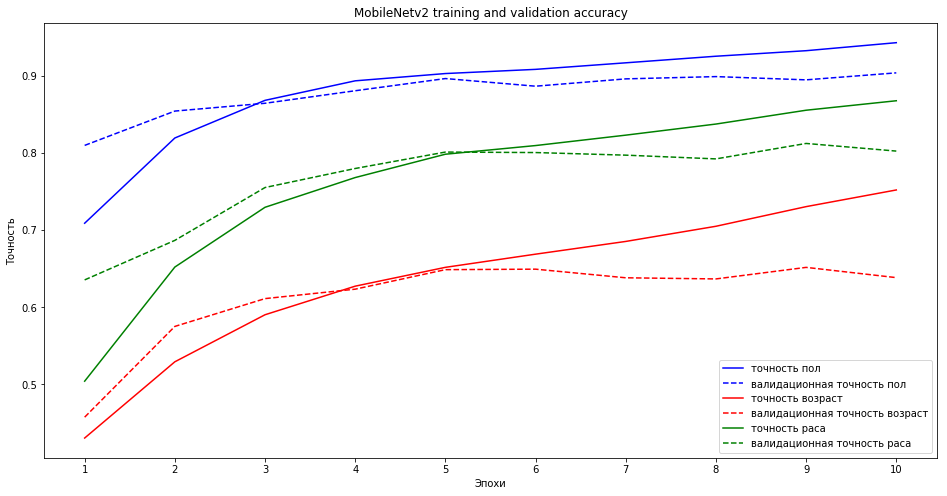

In [26]:
df = pd.read_csv('results_5.csv') 

x = list(range(1, 11))
plt.figure(figsize=(16,8))
plt.title("MobileNetv2 training and validation accuracy")

plt.plot(x, df['accuracy gender'], 'b', label = 'точность пол')
plt.plot(x, df['validation accuracy gender'], 'b--', label = 'валидационная точность пол')

plt.plot(x, df['accuracy age'], 'r', label = 'точность возраст')
plt.plot(x, df['validation accuracy age'], 'r--', label = 'валидационная точность возраст')

plt.plot(x, df['accuracy race'], 'g', label = 'точность раса')
plt.plot(x, df['validation accuracy race'], 'g--', label = 'валидационная точность раса')

plt.xticks(range(1, 11))
plt.xlabel("Эпохи")
plt.ylabel("Точность")
plt.legend();